### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import geocoder
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Reading the table from wikipedia using pandas

In [2]:
raw=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df=pd.DataFrame(raw[0])
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Removing not assigned Boroughs

In [3]:
df_clean=df.copy()
df_clean.drop(index=df[df['Borough']=='Not assigned'].index, inplace=True)

#### Checking for any error figures in cleaned table

In [4]:
df_clean.isnull().sum()  #The result shows no further errors in the table

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

#### Displaying the dataframe

In [5]:
#Resetting the index of the cleaned table

df_clean.reset_index(drop=True, inplace=True)
df_clean.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


#### Number of rows in the dataframe

In [6]:
print(f'Total number of rows in the dataframe amounts to {df_clean.shape[0]}.')

Total number of rows in the dataframe amounts to 103.


#### Importing the coordinates table

In [7]:
coord_df=pd.read_csv('http://cocl.us/Geospatial_data')
coord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merging the dataframes

In [8]:
merged_df=pd.merge(df_clean, coord_df, how='left', on='Postal Code')
merged_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Initial mapping of the Neighborhoods in Toronto

In [9]:
t_latitude=43.6532
t_longitude=-79.3832
toronto_map=folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

for lat, lng, pc, borough, neighborhood in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Postal Code'],
                                              merged_df['Borough'], merged_df['Neighborhood']):
    label=f'{pc},{borough},{neighborhood}'
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng], popup=label, radius=5, color='yellow', fill=True, fill_color='#3186cc', fill_opacity=0.7,
                       parse_html=False).add_to(toronto_map)
    
toronto_map

#### Foursquare credentials & Getting the venues per postal code

In [10]:
CLIENT_ID='VVOCI1PR4IP22KIAOLXUDGIXNSKTDKVJQSKRZX0DQQ52PFVQ'
CLIENT_SECRET='PD4FDWQMU5ZSVMWOIQCKKOPHIVVMKMZGBEL5JGXZ4UBAKTMO'
VERSION='20180605'

In [11]:
RADIUS=1500
LIMIT=100
LAT=float(merged_df[merged_df['Postal Code']=='M1X'].iloc[:, 3])
LNG=float(merged_df[merged_df['Postal Code']=='M1X'].iloc[:, 4])
url=f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={LAT},{LNG}&v={VERSION}&radius={RADIUS}&limit={LIMIT}'

In [12]:
results=requests.get(url).json()

In [13]:
def getNearbyVenues(pc, borough, neighborhood, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for pc, borough, neighborhood, lat, lng in zip(pc, borough, neighborhood, latitudes, longitudes):
        if pc=='M1X' or pc=='M9A' or pc=='M9B' or pc=='M2L':
            radius=1500
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit)

            # make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                pc, 
                borough, 
                neighborhood, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        else:
            radius=500
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit)

            # make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                pc, 
                borough, 
                neighborhood, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                             'Borough', 
                             'Neighborhood', 
                             'PC Latitude', 
                             'PC Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return nearby_venues

In [14]:
venue_df=getNearbyVenues(merged_df['Postal Code'], 
                merged_df['Borough'], 
                merged_df['Neighborhood'], 
                merged_df['Latitude'], 
                merged_df['Longitude'])

In [15]:
# Testing if all postal codes have venues extracted from the API
org_list=merged_df['Postal Code'].unique().tolist()
test_list=venue_df['Postal Code'].unique().tolist()
for i in org_list:
    if i not in test_list:
        print(i)

In [16]:
venue_df.head()

,Postal Code,Borough,Neighborhood,PC Latitude,PC Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,North York,Parkwoods,43.753259,-79.329656,Sun Life,43.754760,-79.332783,Construction & Landscaping
2,M3A,North York,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [17]:
venue_df.groupby('Postal Code').count().head()

,Borough,Neighborhood,PC Latitude,PC Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,,,
M1B,1,1,1,1,1,1,1,1
M1C,2,2,2,2,2,2,2,2
M1E,7,7,7,7,7,7,7,7
M1G,3,3,3,3,3,3,3,3
M1H,9,9,9,9,9,9,9,9


In [18]:
venue_dummy=pd.get_dummies(venue_df, 
                           columns=['Venue Category'],
                           drop_first=True)

In [19]:
venue_grouped=venue_dummy.drop(['Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
venue_grouped=venue_grouped.groupby('Postal Code').mean()
venue_grouped.reset_index(inplace=True)

#Resetting columns to remove unnecessary parts
expr1=lambda col: col[1] if len(col)>1 else col[0]
column_list=[col.split('_') for i,col in enumerate(venue_grouped.columns.values)]
column_list=[expr1(col) for col in column_list]
column_list

venue_grouped.columns=column_list
venue_grouped.head()

,Postal Code,PC Latitude,PC Longitude,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,43.806686,-79.194353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Identifying the top 5 venues for each postal code

In [20]:
# Formula for sorting the most common revenues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = venue_grouped['Postal Code']

for ind in np.arange(venue_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,PC Latitude,Fast Food Restaurant,Electronics Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Ethiopian Restaurant
1,M1C,PC Latitude,Bar,Moving Target,Construction & Landscaping,Convenience Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
2,M1E,PC Latitude,Mexican Restaurant,Intersection,Bank,Electronics Store,Medical Center,Breakfast Spot,Rental Car Location,Falafel Restaurant,Event Space
3,M1G,PC Latitude,Coffee Shop,Korean Restaurant,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
4,M1H,PC Latitude,Thai Restaurant,Gas Station,Fried Chicken Joint,Lounge,Caribbean Restaurant,Bank,Bakery,Athletics & Sports,Hakka Restaurant


#### Clustering

In [22]:
features=venue_grouped.drop(['Postal Code', 'PC Latitude', 'PC Longitude'], axis=1)
features.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0

In [23]:
clusters=5
KModel=KMeans(n_clusters=clusters, random_state=42).fit(features)
KModel.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 4,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 3, 1, 1, 1, 1, 2, 3, 0, 1, 2, 1, 1])

In [24]:
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', KModel.labels_)
toronto_merged=neighborhoods_venues_sorted
toronto_merged=toronto_merged.merge(merged_df[['Postal Code', 
                                               'Borough', 
                                               'Neighborhood', 
                                               'Latitude', 
                                               'Longitude']], on='Postal Code', how='left')

#Mapping clusters to names refer cells after the toronto map for details on naming the clusters
toronto_merged['Mapped Clusters']=toronto_merged['Cluster Labels'].map({0:'Urban Core', 1:'Food & Cafe', 2: 'Suburban', 
                                                                        3: 'Outdoor Leisure', 4: 'Retirement'})  

#Sorting columns in the right order

column_list_t=toronto_merged.columns
sorted_cols=['Postal Code', 'Cluster Labels','Mapped Clusters', 'Borough', 'Neighborhood', 'Latitude',
       'Longitude', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue']


toronto_merged=toronto_merged[sorted_cols]
toronto_merged.head()



,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,1,Food & Cafe,Scarborough,"Malvern, Rouge",43.806686,-79.194353,PC Latitude,Fast Food Restaurant,Electronics Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Ethiopian Restaurant
1,M1C,1,Food & Cafe,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,PC Latitude,Bar,Moving Target,Construction & Landscaping,Convenience Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
2,M1E,1,Food & Cafe,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,PC Latitude,Mexican Restaurant,Intersection,Bank,Electronics Store,Medical Center,Breakfast Spot,Rental Car Location,Falafel Restaurant,Event Space
3,M1G,1,Food & Cafe,Scarborough,Woburn,43.770992,-79.216917,PC Latitude,Coffee Shop,Korean Restaurant,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
4,M1H,1,Food & Cafe,Scarborough,Cedarbrae,43.773136,-79.239476,PC Latitude,Thai Restaurant,Gas Station,Fried Chicken Joint,Lounge,Caribbean Restaurant,Bank,Bakery,Athletics & Sports,Hakka Restaurant


In [25]:
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, pc, neighborhood, cluster, cluster_name in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Postal Code'], 
                                 toronto_merged['Neighborhood'], 
                                 toronto_merged['Cluster Labels'], toronto_merged['Mapped Clusters']):
    label = folium.Popup(str(pc) + ', ' + str(neighborhood) +' (Cluster ' + str(cluster+1) + ', ' + str(cluster_name) + ')', 
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Using Elbow method to identify the ideal n_clusters

In [26]:
error=[]
max_clusters=10+1
for i in range(1, max_clusters):
    error_model=KMeans(n_clusters=i).fit(features)
    error.append(error_model.inertia_)

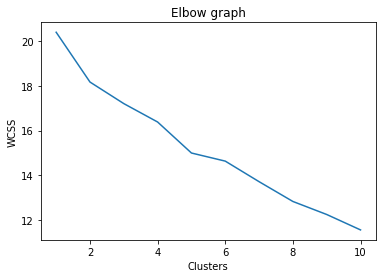

In [27]:
#Plotting to visualize the elbow method

cluster_list=list(range(1,max_clusters))
plt.plot(cluster_list, error)
plt.title('Elbow graph')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()


### Naming Clusters

#### Cluster 1 Name: Urban Core

In [28]:
cluster1=toronto_merged[toronto_merged['Cluster Labels']==0]
cluster1.head().iloc[:, 0:11]

,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
14,M1V,0,Urban Core,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,PC Latitude,Park,Playground,Eastern European Restaurant
23,M2P,0,Urban Core,North York,York Mills West,43.752758,-79.400049,PC Latitude,Park,Bank,Convenience Store
25,M3A,0,Urban Core,North York,Parkwoods,43.753259,-79.329656,PC Latitude,Park,Construction & Landscaping,Food & Drink Shop
30,M3K,0,Urban Core,North York,Downsview,43.737473,-79.464763,PC Latitude,Snack Place,Bus Stop,Park
40,M4J,0,Urban Core,East York,East Toronto,43.685347,-79.338106,PC Latitude,Park,Convenience Store,Coffee Shop


#### Cluster 2 Name: Food and Cafe Joint

In [29]:
cluster2=toronto_merged[toronto_merged['Cluster Labels']==1]
cluster2.head().iloc[:, 0:11]

,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M1B,1,Food & Cafe,Scarborough,"Malvern, Rouge",43.806686,-79.194353,PC Latitude,Fast Food Restaurant,Electronics Store,Distribution Center
1,M1C,1,Food & Cafe,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,PC Latitude,Bar,Moving Target,Construction & Landscaping
2,M1E,1,Food & Cafe,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,PC Latitude,Mexican Restaurant,Intersection,Bank
3,M1G,1,Food & Cafe,Scarborough,Woburn,43.770992,-79.216917,PC Latitude,Coffee Shop,Korean Restaurant,Eastern European Restaurant
4,M1H,1,Food & Cafe,Scarborough,Cedarbrae,43.773136,-79.239476,PC Latitude,Thai Restaurant,Gas Station,Fried Chicken Joint


#### Cluster 3 Name: Suburban (Based on high availability of fast food and public transport)

In [30]:
cluster3=toronto_merged[toronto_merged['Cluster Labels']==2]
cluster3.head().iloc[:, 0:11]

,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
81,M6N,2,Suburban,York,"Runnymede, The Junction North",43.673185,-79.487262,PC Latitude,Pizza Place,Grocery Store,Brewery
96,M9L,2,Suburban,North York,Humber Summit,43.756303,-79.565963,PC Latitude,Pizza Place,Eastern European Restaurant,Discount Store
100,M9R,2,Suburban,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,PC Latitude,Pizza Place,Bus Line,Sandwich Place


#### Cluster 4 Name: Outdoor Leisure

In [31]:
cluster4=toronto_merged[toronto_merged['Cluster Labels']==3]
cluster4.head().iloc[:, 0:11]

,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
91,M8Y,3,Outdoor Leisure,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,PC Latitude,Baseball Field,Electronics Store,Dog Run
97,M9M,3,Outdoor Leisure,North York,"Humberlea, Emery",43.724766,-79.532242,PC Latitude,Baseball Field,Food Service,Electronics Store


#### Cluster 5 Name: Retirement 

In [32]:
cluster5=toronto_merged[toronto_merged['Cluster Labels']==4]
cluster5.head().iloc[:, 0:11]

,Postal Code,Cluster Labels,Mapped Clusters,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
21,M2M,4,Retirement,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,PC Latitude,Home Service,Electronics Store,Distribution Center
